In [22]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras import optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

<ipython-input-1-b9f0bb1fd076>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
#import data
df = pd.read_csv('02_Brexit_Tweets_19_20/yahoo_GBPEUR.csv')
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-01-01,1.11240,1.09740,1.11000,1.10790,0.0,1.10790
1,2019-01-02,1.11324,1.10710,1.11254,1.11264,0.0,1.11264
2,2019-01-03,1.10887,1.10300,1.10610,1.10570,0.0,1.10570
3,2019-01-04,1.11650,1.10740,1.10849,1.10851,0.0,1.10851
4,2019-01-07,1.11656,1.11215,1.11576,1.11593,0.0,1.11593


In [3]:
#filter column
dataset = df[['Open', 'High', 'Low', 'Close']]
dataset.head()

,Open,High,Low,Close
0,1.11000,1.11240,1.09740,1.10790
1,1.11254,1.11324,1.10710,1.11264
2,1.10610,1.10887,1.10300,1.10570
3,1.10849,1.11650,1.10740,1.10851
4,1.11576,1.11656,1.11215,1.11593


In [4]:
scaler = MinMaxScaler()
norm_data = scaler.fit_transform(dataset)
data = pd.DataFrame(data=norm_data, columns=['Open', 'High', 'Low', 'Close'])
data.head()

,Open,High,Low,Close
0,0.341705,0.248108,0.304827,0.329935
1,0.359328,0.254730,0.370873,0.362810
2,0.314646,0.220278,0.342957,0.314676
3,0.331229,0.280432,0.372915,0.334166
4,0.381669,0.280905,0.405256,0.385629


In [5]:
def load_data(data, seq_len):
    amount_of_features = len(data.columns)
    dataset = data.to_numpy() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(dataset) - sequence_length):
        result.append(dataset[index: index + sequence_length])

    result = np.array(result)
    days = round(0.9 * result.shape[0])     #split data training 
    train = result[:int(days), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(days):, :-1]
    y_test = result[int(days):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
    
    return [x_train, y_train, x_test, y_test]

In [6]:
#lstm model
def build_model2(layers):
    
   
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16, activation='tanh'))     #tanh or relu   
    model.add(Dense(1,activation='tanh'))
        
    rmsprop = optimizers.RMSprop(lr=0.005)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
#initialization
window = 1
test_split = 0.1
batch = 4

print('Loading data.....\n')

X_train, y_train, X_test, y_test = load_data(data, window)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


print('\nData loaded. \nTraining process...\n')

#choose model
model = build_model2([4,window,1])
model.summary()
#fit data into model
history = model.fit(
                    X_train,
                    y_train,
                    batch_size=batch,
                    epochs = 500,
                    validation_split=test_split,
                    verbose=1)


Loading data.....

X_train (452, 1, 4)
y_train (452,)
X_test (50, 1, 4)
y_test (50,)

Data loaded. 
Training process...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            68096     
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
T

102/102 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 0.0027 - val_loss: 5.0154e-04 - val_accuracy: 0.0000e+00
Epoch 47/500
102/102 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.0023 - val_loss: 6.8561e-04 - val_accuracy: 0.0000e+00
Epoch 48/500
102/102 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.0083 - val_loss: 4.6987e-04 - val_accuracy: 0.0000e+00
Epoch 49/500
102/102 [==============================] - 0s 2ms/step - loss: 9.7691e-04 - accuracy: 0.0025 - val_loss: 4.0105e-04 - val_accuracy: 0.0000e+00
Epoch 50/500
102/102 [==============================] - 0s 2ms/step - loss: 0.0013 - accuracy: 0.0072 - val_loss: 6.3821e-04 - val_accuracy: 0.0000e+00
Epoch 51/500
102/102 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.0017 - val_loss: 7.8064e-04 - val_accuracy: 0.0000e+00
Epoch 52/500
102/102 [==============================] - 0s 2ms/step - loss: 8.5243e-04 - accuracy

102/102 [==============================] - 0s 3ms/step - loss: 9.0480e-04 - accuracy: 0.0014 - val_loss: 5.6007e-04 - val_accuracy: 0.0000e+00
Epoch 100/500
102/102 [==============================] - 0s 3ms/step - loss: 7.7600e-04 - accuracy: 3.9250e-04 - val_loss: 3.4862e-04 - val_accuracy: 0.0000e+00
Epoch 101/500
102/102 [==============================] - 0s 3ms/step - loss: 8.9208e-04 - accuracy: 0.0022 - val_loss: 4.3361e-04 - val_accuracy: 0.0000e+00
Epoch 102/500
102/102 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.0058 - val_loss: 3.5332e-04 - val_accuracy: 0.0000e+00
Epoch 103/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.0043 - val_loss: 4.7626e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.0031 - val_loss: 3.1614e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
102/102 [==============================] - 0s 3ms/step - loss: 9.7

Epoch 152/500
102/102 [==============================] - 0s 2ms/step - loss: 7.7968e-04 - accuracy: 0.0044 - val_loss: 3.6235e-04 - val_accuracy: 0.0000e+00
Epoch 153/500
102/102 [==============================] - 0s 3ms/step - loss: 9.8761e-04 - accuracy: 0.0046 - val_loss: 5.7912e-04 - val_accuracy: 0.0000e+00
Epoch 154/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.0075 - val_loss: 2.9955e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
102/102 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.0047 - val_loss: 3.1938e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
102/102 [==============================] - 0s 2ms/step - loss: 6.7835e-04 - accuracy: 5.0113e-04 - val_loss: 3.8034e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
102/102 [==============================] - 0s 2ms/step - loss: 8.9502e-04 - accuracy: 0.0022 - val_loss: 4.9570e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
102/102 [==============================] - 0s 3m

102/102 [==============================] - 0s 3ms/step - loss: 8.5825e-04 - accuracy: 0.0057 - val_loss: 3.0750e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
102/102 [==============================] - 0s 3ms/step - loss: 9.4179e-04 - accuracy: 0.0112 - val_loss: 6.0201e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.0149 - val_loss: 7.7310e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
102/102 [==============================] - 0s 3ms/step - loss: 7.7956e-04 - accuracy: 0.0011 - val_loss: 3.4425e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.0070 - val_loss: 4.2405e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.0062 - val_loss: 3.0440e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
102/102 [==============================] - 0s 2ms/step - loss: 8.5328e

Epoch 257/500
102/102 [==============================] - 0s 2ms/step - loss: 9.6197e-04 - accuracy: 0.0018 - val_loss: 3.1254e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.0041 - val_loss: 2.9520e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
102/102 [==============================] - 0s 3ms/step - loss: 9.1246e-04 - accuracy: 0.0023 - val_loss: 4.3418e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
102/102 [==============================] - 0s 3ms/step - loss: 9.9162e-04 - accuracy: 0.0079 - val_loss: 7.6614e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
102/102 [==============================] - 0s 2ms/step - loss: 9.3116e-04 - accuracy: 0.0027 - val_loss: 6.6902e-04 - val_accuracy: 0.0000e+00
Epoch 262/500
102/102 [==============================] - 0s 2ms/step - loss: 7.7002e-04 - accuracy: 0.0014 - val_loss: 3.1840e-04 - val_accuracy: 0.0000e+00
Epoch 263/500
102/102 [==============================] - 0s 2m

102/102 [==============================] - 0s 3ms/step - loss: 7.5843e-04 - accuracy: 0.0033 - val_loss: 6.8037e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
102/102 [==============================] - 0s 3ms/step - loss: 7.2864e-04 - accuracy: 0.0018 - val_loss: 3.7241e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
102/102 [==============================] - 0s 2ms/step - loss: 8.0384e-04 - accuracy: 0.0016 - val_loss: 4.2738e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
102/102 [==============================] - 0s 2ms/step - loss: 8.2208e-04 - accuracy: 0.0045 - val_loss: 7.7191e-04 - val_accuracy: 0.0000e+00
Epoch 313/500
102/102 [==============================] - 0s 3ms/step - loss: 8.1032e-04 - accuracy: 0.0051 - val_loss: 3.8523e-04 - val_accuracy: 0.0000e+00
Epoch 314/500
102/102 [==============================] - 0s 3ms/step - loss: 8.8668e-04 - accuracy: 0.0032 - val_loss: 3.9308e-04 - val_accuracy: 0.0000e+00
Epoch 315/500
102/102 [==============================] - 0s 3ms/step - l

102/102 [==============================] - 0s 3ms/step - loss: 7.3588e-04 - accuracy: 0.0017 - val_loss: 3.0209e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
102/102 [==============================] - 0s 3ms/step - loss: 8.7762e-04 - accuracy: 0.0020 - val_loss: 3.2028e-04 - val_accuracy: 0.0000e+00
Epoch 363/500
102/102 [==============================] - 0s 3ms/step - loss: 9.0349e-04 - accuracy: 0.0023 - val_loss: 8.3004e-04 - val_accuracy: 0.0000e+00
Epoch 364/500
102/102 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 0.0044 - val_loss: 3.5936e-04 - val_accuracy: 0.0000e+00
Epoch 365/500
102/102 [==============================] - 0s 3ms/step - loss: 8.3715e-04 - accuracy: 0.0023 - val_loss: 3.5595e-04 - val_accuracy: 0.0000e+00
Epoch 366/500
102/102 [==============================] - 0s 3ms/step - loss: 8.6767e-04 - accuracy: 0.0012 - val_loss: 3.0506e-04 - val_accuracy: 0.0000e+00
Epoch 367/500
102/102 [==============================] - 0s 2ms/step - loss:

102/102 [==============================] - 0s 2ms/step - loss: 8.9582e-04 - accuracy: 0.0058 - val_loss: 3.1894e-04 - val_accuracy: 0.0000e+00
Epoch 414/500
102/102 [==============================] - 0s 3ms/step - loss: 8.6711e-04 - accuracy: 0.0034 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 415/500
102/102 [==============================] - 0s 3ms/step - loss: 7.6660e-04 - accuracy: 0.0031 - val_loss: 6.4296e-04 - val_accuracy: 0.0000e+00
Epoch 416/500
102/102 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.0064 - val_loss: 3.2612e-04 - val_accuracy: 0.0000e+00
Epoch 417/500
102/102 [==============================] - 0s 2ms/step - loss: 7.1215e-04 - accuracy: 0.0029 - val_loss: 3.8045e-04 - val_accuracy: 0.0000e+00
Epoch 418/500
102/102 [==============================] - 0s 3ms/step - loss: 8.7476e-04 - accuracy: 0.0035 - val_loss: 3.7101e-04 - val_accuracy: 0.0000e+00
Epoch 419/500
102/102 [==============================] - 0s 2ms/step - loss: 8.3

102/102 [==============================] - 0s 3ms/step - loss: 9.9846e-04 - accuracy: 0.0091 - val_loss: 3.1306e-04 - val_accuracy: 0.0000e+00
Epoch 466/500
102/102 [==============================] - 0s 2ms/step - loss: 6.7462e-04 - accuracy: 0.0034 - val_loss: 3.0664e-04 - val_accuracy: 0.0000e+00
Epoch 467/500
102/102 [==============================] - 0s 3ms/step - loss: 7.6753e-04 - accuracy: 0.0013 - val_loss: 3.2897e-04 - val_accuracy: 0.0000e+00
Epoch 468/500
102/102 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.0123 - val_loss: 3.8483e-04 - val_accuracy: 0.0000e+00
Epoch 469/500
102/102 [==============================] - 0s 3ms/step - loss: 6.7129e-04 - accuracy: 0.0012 - val_loss: 8.5273e-04 - val_accuracy: 0.0000e+00
Epoch 470/500
102/102 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.0083 - val_loss: 3.2556e-04 - val_accuracy: 0.0000e+00
Epoch 471/500
102/102 [==============================] - 0s 3ms/step - loss: 0.0

In [8]:
#training error
print('Training error:- MSE: %.4f ' % history.history['loss'][-1])
print('\t\t RMSE: %.4f ' % math.sqrt(history.history['loss'][-1]))

#testing error
print('\nTesting error:- MSE: %.4f ' % history.history['val_loss'][-1])
print('\t\tRMSE: %.4f ' % math.sqrt(history.history['val_loss'][-1]))

Training error:- MSE: 0.0010 
		 RMSE: 0.0310 

Testing error:- MSE: 0.0003 
		RMSE: 0.0173 


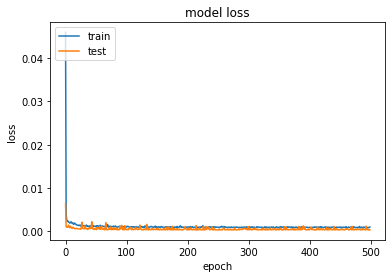

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
#print(X_test[-1])
diff=[]
ratio=[]
predict = model.predict(X_test)
print('data\t test\t\t\t prediction\t difference')
for u in range(len(y_test)):
    prediction = predict[u][0]
    ratio.append((y_test[u]/prediction))
    diff.append(abs(y_test[u]- prediction))
    print(u, '\t' , y_test[u], '\t' , prediction, '\t' , '%.4f'% abs(y_test[u]- prediction))

data	 test			 prediction	 difference
0 	 0.321958644661418 	 0.32982343 	 0.0079
1 	 0.28637774097558655 	 0.2981092 	 0.0117
2 	 0.2893600414727455 	 0.2923156 	 0.0030
3 	 0.316063495633208 	 0.3047758 	 0.0113
4 	 0.31356653208970275 	 0.3148272 	 0.0013
5 	 0.3250798490908 	 0.33471242 	 0.0096
6 	 0.3459559525709217 	 0.3412869 	 0.0047
7 	 0.3438062488579705 	 0.32720137 	 0.0166
8 	 0.38132850035842214 	 0.36426747 	 0.0171
9 	 0.30954327891000144 	 0.33989713 	 0.0304
10 	 0.3563596917324876 	 0.3351097 	 0.0212
11 	 0.3316686909709965 	 0.3171279 	 0.0145
12 	 0.36974573139121425 	 0.3419811 	 0.0278
13 	 0.42724369123970973 	 0.43281975 	 0.0056
14 	 0.4305037996013148 	 0.45679682 	 0.0263
15 	 0.35504258480374506 	 0.36266837 	 0.0076
16 	 0.38611489835622237 	 0.37338474 	 0.0127
17 	 0.3773755259539522 	 0.36585224 	 0.0115
18 	 0.395269328936914 	 0.3854597 	 0.0098
19 	 0.4056730680984799 	 0.41124603 	 0.0056
20 	 0.3888193909889388 	 0.3985867 	 0.0098
21 	 0.42148661

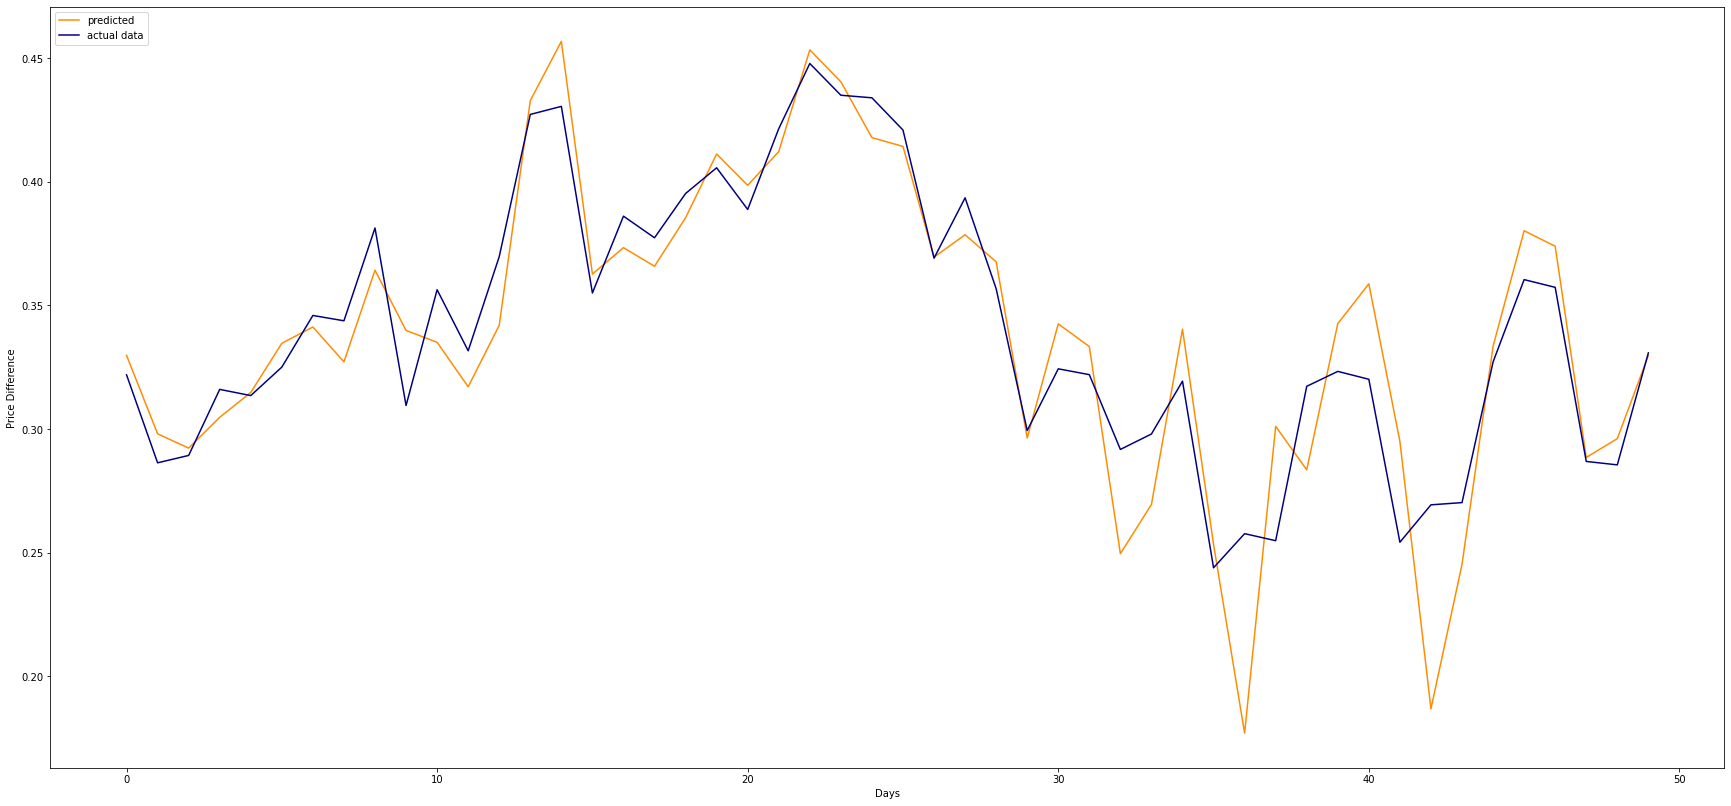

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 14))
plt.plot(predict,color='darkorange', label='predicted')
plt.plot(y_test,color='navy', label='actual data')
plt.ylabel('Price Difference')
plt.xlabel('Days')
plt.legend(loc='upper left')
plt.show()